In [18]:
import numpy as np
import tensorflow as tf
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import load_model
from IPython.display import clear_output


# Scaling

In [19]:
# Custom scaling function
def custom_scaling(X):
    return np.array([(X[:, 0] - L_min) / (L_max - L_min), 
                     (X[:, 1] - C_min) / (C_max - C_min),
                     (X[:, 2] - fsw_min) / (fsw_max - fsw_min),
                     (X[:, 3] - t_dt_min) / (t_dt_max - t_dt_min),
                     (X[:, 4] - d_cycle_min) / (d_cycle_max - d_cycle_min)]).T

# Initialization

In [59]:
csv_file_path = r"D:\Krishna\ai-power-converter\new\simulation_results_10_pc.csv"

# Define custom scaling ranges for each input feature
L_min, L_max = 30e-6, 2000e-6
C_min, C_max = 20e-6, 1000e-6
fsw_min, fsw_max = 20e3, 200e3
t_dt_min, t_dt_max = 175.2e-9, 262.8e-9
d_cycle_min, d_cycle_max = 0.2, 0.35

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

# Define a custom callback to print custom information at the end of each epoch
class PrintEpochInfo(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs=None):
        clear_output(wait=True)
        print(f"Epoch {epoch+1}/{self.params['epochs']}, Loss: {logs['loss']}, Val Loss: {logs['val_loss']}")

# Define early stopping criteria
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0.001, patience=5, verbose=1, mode='auto', restore_best_weights=True)

# Define the learning rate scheduler
lr_scheduler = tf.keras.callbacks.ReduceLROnPlateau(factor=0.5, patience=3, min_lr=1e-6)

 ## Current
 

Epoch 5/100, Loss: 0.10786514729261398, Val Loss: 0.06915032863616943
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 719us/step


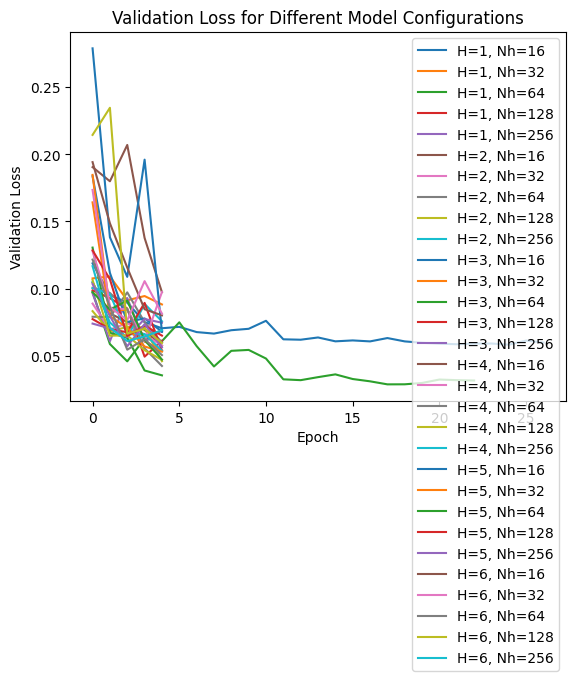

Model with H=1 and Nh=16:
MSE: 0.058260172605514526
MAE: 0.05826018625851688
RMSE: 0.1127455724816606
R-squared: 0.9939121261707702
MAPE: 13.485911378718763%
Model with H=1 and Nh=32:
MSE: 0.10919751226902008
MAE: 0.10919748645674067
RMSE: 0.3228601474099991
R-squared: 0.9601238921008496
MAPE: 14.625668875501416%
Model with H=1 and Nh=64:
MSE: 0.028892232105135918
MAE: 0.028892224835585865
RMSE: 0.061917389640406696
R-squared: 0.998107203505193
MAPE: 4.973949898634357%
Model with H=1 and Nh=128:
MSE: 0.09882452338933945
MAE: 0.09882451833679737
RMSE: 0.22128624677099593
R-squared: 0.9780588507079636
MAPE: 11.316687403654061%
Model with H=1 and Nh=256:
MSE: 0.09644526243209839
MAE: 0.09644526195178078
RMSE: 0.21273185618962126
R-squared: 0.9781365193681941
MAPE: 12.254288849534682%
Model with H=2 and Nh=16:
MSE: 0.10570058226585388
MAE: 0.10570058143693375
RMSE: 0.3643138842545108
R-squared: 0.9436407479148757
MAPE: 11.412690702182278%
Model with H=2 and Nh=32:
MSE: 0.08931558579206467


In [7]:
# Load your simulation data
df_current = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_current = df_current[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (average_current, delta_current)
y_current = df_current[['average_current', 'delta_current']].values  # Adjust column names as per your dataset

X_scaled_current = custom_scaling(X_current)

# Split the dataset into training, validation, and testing sets
X_train_current, X_temp_current, y_train_current, y_temp_current = train_test_split(X_scaled_current, y_current, test_size=0.3, random_state=42)
X_val_current, X_test_current, y_val_current, y_test_current = train_test_split(X_temp_current, y_temp_current, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_current = {}
maes_current = {}
rmses_current = {}
r2_scores_current = {}
mapes_current = {}

# Initialize a dictionary to store the training history for each configuration
histories_current = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_current = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_current.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_current.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_current.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_current.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_current.add(tf.keras.layers.Dense(2, activation='softplus'))  

        # Compile the model
        model_current.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_current = model_current.fit(X_train_current, y_train_current, epochs=100, batch_size=32, validation_data=(X_val_current, y_val_current), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_current[(H, Nh)] = history_current

        # Evaluate the model on the testing set
        predictions_current = model_current.predict(X_test_current)

        # Evaluate the model on the testing set and calculate MSE
        mse_current = model_current.evaluate(X_test_current, y_test_current, verbose=0)
        mses_current[(H, Nh)] = mse_current

        # Calculate Mean Absolute Error (MAE)
        mae_current = mean_absolute_error(y_test_current, predictions_current)
        maes_current[(H, Nh)] = mae_current

        # Calculate Root Mean Squared Error (RMSE)
        rmse_current = np.sqrt(mean_squared_error(y_test_current, predictions_current))
        rmses_current[(H, Nh)] = rmse_current

        # Calculate R-squared (R2) Score
        r2_current = r2_score(y_test_current, predictions_current)
        r2_scores_current[(H, Nh)] = r2_current

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_current = np.mean(np.abs((y_test_current - predictions_current) / y_test_current)) * 100
        mapes_current[(H, Nh)] = mape_current

# Plot the validation loss for each configuration
for (H, Nh), history_current in histories_current.items():
    plt.plot(history_current.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_current in mses_current.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_current}')
    print(f'MAE: {maes_current[(H, Nh)]}')
    print(f'RMSE: {rmses_current[(H, Nh)]}')
    print(f'R-squared: {r2_scores_current[(H, Nh)]}')
    print(f'MAPE: {mapes_current[(H, Nh)]}%')


In [8]:
# Rank combinations based on their MSE values
ranked_combinations_current = sorted(mses_current.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_current) in enumerate(ranked_combinations_current, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_current}")


Rank 1: Combination H=1, Nh=64 - MSE: 0.028892232105135918
Rank 2: Combination H=1, Nh=16 - MSE: 0.058260172605514526
Rank 3: Combination H=3, Nh=256 - MSE: 0.07424424588680267
Rank 4: Combination H=3, Nh=128 - MSE: 0.07755713164806366
Rank 5: Combination H=2, Nh=64 - MSE: 0.07914397120475769
Rank 6: Combination H=2, Nh=128 - MSE: 0.08229921758174896
Rank 7: Combination H=2, Nh=32 - MSE: 0.08931558579206467
Rank 8: Combination H=5, Nh=64 - MSE: 0.09643860906362534
Rank 9: Combination H=1, Nh=256 - MSE: 0.09644526243209839
Rank 10: Combination H=1, Nh=128 - MSE: 0.09882452338933945
Rank 11: Combination H=4, Nh=64 - MSE: 0.10014661401510239
Rank 12: Combination H=4, Nh=256 - MSE: 0.10099916160106659
Rank 13: Combination H=5, Nh=256 - MSE: 0.10331444442272186
Rank 14: Combination H=2, Nh=256 - MSE: 0.10478460788726807
Rank 15: Combination H=2, Nh=16 - MSE: 0.10570058226585388
Rank 16: Combination H=4, Nh=128 - MSE: 0.10571945458650589
Rank 17: Combination H=1, Nh=32 - MSE: 0.1091975122690

In [67]:
# Specify the combination you want to call
H = 1
Nh = 64

# Retrieve the model for the specified combination
selected_model_current = histories_current[(H, Nh)].model
selected_model_current.save("current_delta_current.h5")

# Use the trained model to make predictions on the testing set
predictions_current = selected_model_current.predict(X_test_current)

# Evaluate the model on the testing set
mse_current = selected_model_current.evaluate(X_test_current, y_test_current)
print("Mean Squared Error on Testing Set:", mse_current)

# Print the first few predictions
print("Predictions:")
print(predictions_current[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_current[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 319us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 295us/step - loss: 0.0288
Mean Squared Error on Testing Set: 0.028892232105135918
Predictions:
[[2.3446236  0.04950639]
 [2.8509765  0.1280797 ]
 [2.945978   0.41950807]
 [2.5222967  0.09426114]
 [4.0391097  0.07538851]]
True Values:
[[2.34783152 0.04462712]
 [2.88684801 0.16671753]
 [2.92535202 0.46045274]
 [2.5154775  0.08426515]
 [4.04247379 0.0762018 ]]


## Voltage

Epoch 5/100, Loss: 0.11705856770277023, Val Loss: 0.05305897071957588
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 974us/step


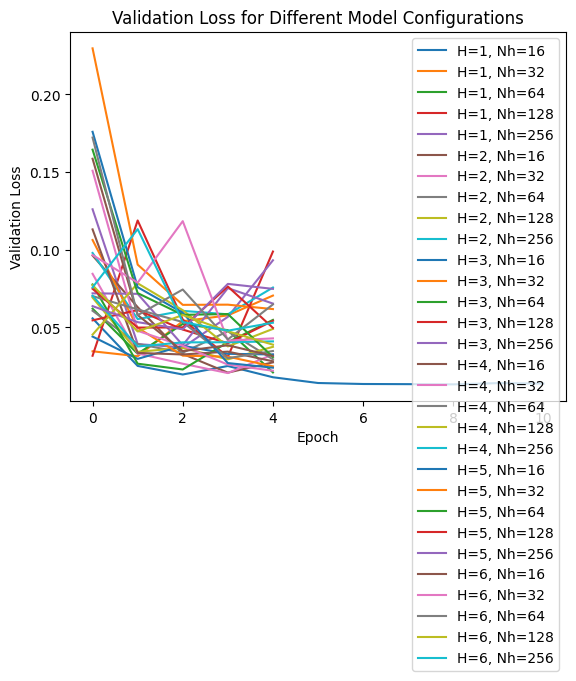

Model with H=1 and Nh=16:
MSE: 0.014097257517278194
MAE: 0.01409725874147738
RMSE: 0.01922111884811454
R-squared: 0.999102732366062
MAPE: 0.4443159373214752%
Model with H=1 and Nh=32:
MSE: 0.03460371121764183
MAE: 0.03460370785078311
RMSE: 0.04355697632411827
R-squared: 0.9953923432145836
MAPE: 1.134985139478942%
Model with H=1 and Nh=64:
MSE: 0.06211790069937706
MAE: 0.06211790980253774
RMSE: 0.06958424306772036
R-squared: 0.988240564106503
MAPE: 2.0549953998281194%
Model with H=1 and Nh=128:
MSE: 0.03210341930389404
MAE: 0.03210343849727023
RMSE: 0.04174394842220334
R-squared: 0.9957679408948221
MAPE: 1.0474147997467587%
Model with H=1 and Nh=256:
MSE: 0.1262567788362503
MAE: 0.1262567614062559
RMSE: 0.13783699568426555
R-squared: 0.9538580152479289
MAPE: 4.054341967838721%
Model with H=2 and Nh=16:
MSE: 0.09651193767786026
MAE: 0.09651196889210893
RMSE: 0.11024604991664828
R-squared: 0.9704817402746783
MAPE: 3.1539980695295213%
Model with H=2 and Nh=32:
MSE: 0.08409122377634048
MAE:

In [69]:
# Load your simulation data
df_voltage = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_voltage = df_voltage[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (average_voltage, delta_voltage)
y_voltage = df_voltage[['average_voltage']].values  # Adjusted column names

X_scaled_voltage = custom_scaling(X_voltage)

# Split the dataset into training, validation, and testing sets
X_train_voltage, X_temp_voltage, y_train_voltage, y_temp_voltage = train_test_split(X_scaled_voltage, y_voltage, test_size=0.3, random_state=42)
X_val_voltage, X_test_voltage, y_val_voltage, y_test_voltage = train_test_split(X_temp_voltage, y_temp_voltage, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_voltage = {}
maes_voltage = {}
rmses_voltage = {}
r2_scores_voltage = {}
mapes_voltage = {}

# Initialize a dictionary to store the training history for each configuration
histories_voltage = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_voltage = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_voltage.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_voltage.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_voltage.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_voltage.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_voltage.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_voltage.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_voltage = model_voltage.fit(X_train_voltage, y_train_voltage, epochs=100, batch_size=32, validation_data=(X_val_voltage, y_val_voltage), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_voltage[(H, Nh)] = history_voltage

        # Evaluate the model on the testing set
        predictions_voltage = model_voltage.predict(X_test_voltage)

        # Evaluate the model on the testing set and calculate MSE
        mse_voltage = model_voltage.evaluate(X_test_voltage, y_test_voltage, verbose=0)
        mses_voltage[(H, Nh)] = mse_voltage

        # Calculate Mean Absolute Error (MAE)
        mae_voltage = mean_absolute_error(y_test_voltage, predictions_voltage)
        maes_voltage[(H, Nh)] = mae_voltage

        # Calculate Root Mean Squared Error (RMSE)
        rmse_voltage = np.sqrt(mean_squared_error(y_test_voltage, predictions_voltage))
        rmses_voltage[(H, Nh)] = rmse_voltage

        # Calculate R-squared (R2) Score
        r2_voltage = r2_score(y_test_voltage, predictions_voltage)
        r2_scores_voltage[(H, Nh)] = r2_voltage

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_voltage = np.mean(np.abs((y_test_voltage - predictions_voltage) / y_test_voltage)) * 100
        mapes_voltage[(H, Nh)] = mape_voltage

# Plot the validation loss for each configuration
for (H, Nh), history_voltage in histories_voltage.items():
    plt.plot(history_voltage.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_voltage in mses_voltage.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_voltage}')
    print(f'MAE: {maes_voltage[(H, Nh)]}')
    print(f'RMSE: {rmses_voltage[(H, Nh)]}')
    print(f'R-squared: {r2_scores_voltage[(H, Nh)]}')
    print(f'MAPE: {mapes_voltage[(H, Nh)]}%')


In [70]:
# Rank combinations based on their MSE values
ranked_combinations_voltage = sorted(mses_voltage.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_voltage) in enumerate(ranked_combinations_voltage, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_voltage}")


Rank 1: Combination H=1, Nh=16 - MSE: 0.014097257517278194
Rank 2: Combination H=1, Nh=128 - MSE: 0.03210341930389404
Rank 3: Combination H=1, Nh=32 - MSE: 0.03460371121764183
Rank 4: Combination H=3, Nh=16 - MSE: 0.044037967920303345
Rank 5: Combination H=4, Nh=128 - MSE: 0.04585367068648338
Rank 6: Combination H=3, Nh=128 - MSE: 0.055037930607795715
Rank 7: Combination H=2, Nh=64 - MSE: 0.06085538864135742
Rank 8: Combination H=1, Nh=64 - MSE: 0.06211790069937706
Rank 9: Combination H=5, Nh=256 - MSE: 0.06340709328651428
Rank 10: Combination H=4, Nh=64 - MSE: 0.06852859258651733
Rank 11: Combination H=2, Nh=128 - MSE: 0.06880154460668564
Rank 12: Combination H=4, Nh=256 - MSE: 0.06956120580434799
Rank 13: Combination H=3, Nh=256 - MSE: 0.07229109108448029
Rank 14: Combination H=6, Nh=256 - MSE: 0.07401450723409653
Rank 15: Combination H=5, Nh=128 - MSE: 0.07543454319238663
Rank 16: Combination H=6, Nh=128 - MSE: 0.0762089341878891
Rank 17: Combination H=3, Nh=64 - MSE: 0.078269205987

In [71]:
# Specify the combination you want to call
H = 1
Nh = 16

# Retrieve the model for the specified combination
selected_model_voltage = histories_voltage[(H, Nh)].model
selected_model_voltage.save("voltage.h5")

# Use the trained model to make predictions on the testing set
predictions_voltage = selected_model_voltage.predict(X_test_voltage)

# Evaluate the model on the testing set
mse_voltage = selected_model_voltage.evaluate(X_test_voltage, y_test_voltage)
print("Mean Squared Error on Testing Set:", mse_voltage)

# Print the first few predictions
print("Predictions:")
print(predictions_voltage[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_voltage[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 287us/step - loss: 0.0141
Mean Squared Error on Testing Set: 0.014097257517278194
Predictions:
[[2.3599186]
 [2.8728087]
 [2.9430137]
 [2.5077908]
 [4.0790486]]
True Values:
[[2.34906904]
 [2.88829668]
 [2.92852685]
 [2.5123539 ]
 [4.04580789]]


### Delta Voltage

Epoch 5/100, Loss: 0.16139569878578186, Val Loss: 0.2804352939128876
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 734us/step


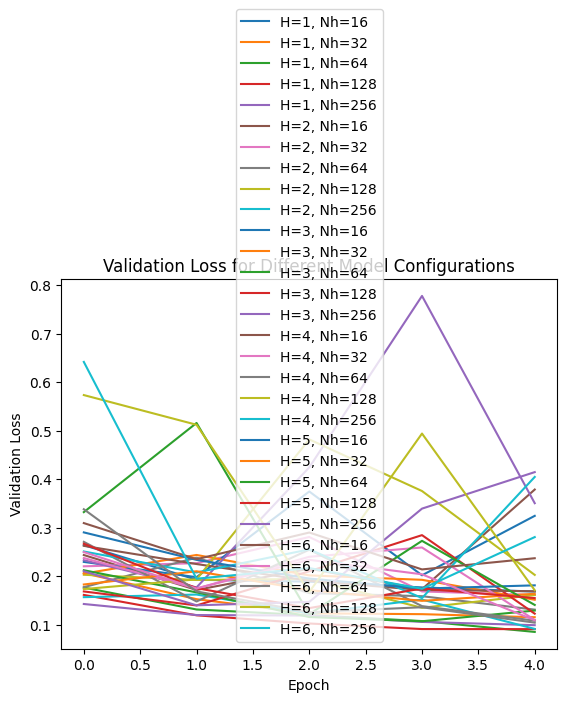

Model with H=1 and Nh=16:
MSE: 0.25734516978263855
MAE: 0.2573453064066703
RMSE: 1.7897933408272992
R-squared: 0.6284713188027455
MAPE: 95.70050625361743%
Model with H=1 and Nh=32:
MSE: 0.199659526348114
MAE: 0.19965949910946773
RMSE: 1.7198511520930846
R-squared: 0.6569414137866874
MAPE: 61.661769622346355%
Model with H=1 and Nh=64:
MSE: 0.16491632163524628
MAE: 0.16491631757425618
RMSE: 1.632025129202651
R-squared: 0.6910841063213145
MAPE: 68.11688322459742%
Model with H=1 and Nh=128:
MSE: 0.14991386234760284
MAE: 0.14991398438903594
RMSE: 1.4893793508909015
R-squared: 0.7427252132162765
MAPE: 56.96214996343062%
Model with H=1 and Nh=256:
MSE: 0.1348344087600708
MAE: 0.13483433171019166
RMSE: 1.2625472547478058
R-squared: 0.8151234389871844
MAPE: 45.34631999735352%
Model with H=2 and Nh=16:
MSE: 0.23924380540847778
MAE: 0.2392437547346639
RMSE: 1.9193043617626993
R-squared: 0.572757674073493
MAPE: 52.83568083713751%
Model with H=2 and Nh=32:
MSE: 0.21703338623046875
MAE: 0.2170333841

In [30]:
# Load your simulation data
df_delta_voltage = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_delta_voltage = df_delta_voltage[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (delta_voltage)
y_delta_voltage = df_delta_voltage[['delta_voltage_percentage']].values  # Adjusted column names

X_scaled_delta_voltage = custom_scaling(X_delta_voltage)

# Split the dataset into training, validation, and testing sets
X_train_delta_voltage, X_temp_delta_voltage, y_train_delta_voltage, y_temp_delta_voltage = train_test_split(X_scaled_delta_voltage, y_delta_voltage, test_size=0.3, random_state=42)
X_val_delta_voltage, X_test_delta_voltage, y_val_delta_voltage, y_test_delta_voltage = train_test_split(X_temp_delta_voltage, y_temp_delta_voltage, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_delta_voltage = {}
maes_delta_voltage = {}
rmses_delta_voltage = {}
r2_scores_delta_voltage = {}
mapes_delta_voltage = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

# Initialize a dictionary to store the training history for each configuration
histories_delta_voltage = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_delta_voltage = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_delta_voltage.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_delta_voltage.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_delta_voltage.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_delta_voltage.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_delta_voltage = model_delta_voltage.fit(X_train_voltage, y_train_delta_voltage, epochs=100, batch_size=32, validation_data=(X_val_voltage, y_val_delta_voltage), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_delta_voltage[(H, Nh)] = history_delta_voltage

        # Evaluate the model on the testing set
        predictions_delta_voltage = model_delta_voltage.predict(X_test_voltage)

        # Evaluate the model on the testing set and calculate MSE
        mse_delta_voltage = model_delta_voltage.evaluate(X_test_voltage, y_test_delta_voltage, verbose=0)
        mses_delta_voltage[(H, Nh)] = mse_delta_voltage

        # Calculate Mean Absolute Error (MAE)
        mae_delta_voltage = mean_absolute_error(y_test_delta_voltage, predictions_delta_voltage)
        maes_delta_voltage[(H, Nh)] = mae_delta_voltage

        # Calculate Root Mean Squared Error (RMSE)
        rmse_delta_voltage = np.sqrt(mean_squared_error(y_test_delta_voltage, predictions_delta_voltage))
        rmses_delta_voltage[(H, Nh)] = rmse_delta_voltage

        # Calculate R-squared (R2) Score
        r2_delta_voltage = r2_score(y_test_delta_voltage, predictions_delta_voltage)
        r2_scores_delta_voltage[(H, Nh)] = r2_delta_voltage

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_delta_voltage = np.mean(np.abs((y_test_delta_voltage - predictions_delta_voltage) / y_test_delta_voltage)) * 100
        mapes_delta_voltage[(H, Nh)] = mape_delta_voltage

# Plot the validation loss for each configuration
for (H, Nh), history_delta_voltage in histories_delta_voltage.items():
    plt.plot(history_delta_voltage.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_delta_voltage in mses_delta_voltage.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_delta_voltage}')
    print(f'MAE: {maes_delta_voltage[(H, Nh)]}')
    print(f'RMSE: {rmses_delta_voltage[(H, Nh)]}')
    print(f'R-squared: {r2_scores_delta_voltage[(H, Nh)]}')
    print(f'MAPE: {mapes_delta_voltage[(H, Nh)]}%')


In [ ]:
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Load your simulation data
df_delta_voltage = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_delta_voltage = df_delta_voltage[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (delta_voltage)
y_delta_voltage = df_delta_voltage[['delta_voltage_percentage']].values  # Adjusted column names

# Scale input features
scaler_X = MinMaxScaler()
X_scaled_delta_voltage = scaler_X.fit_transform(X_delta_voltage)

# Scale output
scaler_y = MinMaxScaler()
y_delta_voltage = scaler_y.fit_transform(y_delta_voltage)

# Split the dataset into training, validation, and testing sets
X_train_delta_voltage, X_temp_delta_voltage, y_train_delta_voltage, y_temp_delta_voltage = train_test_split(X_scaled_delta_voltage, y_delta_voltage, test_size=0.3, random_state=42)
X_val_delta_voltage, X_test_delta_voltage, y_val_delta_voltage, y_test_delta_voltage = train_test_split(X_temp_delta_voltage, y_temp_delta_voltage, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_delta_voltage = {}
maes_delta_voltage = {}
rmses_delta_voltage = {}
r2_scores_delta_voltage = {}
mapes_delta_voltage = {}

# Define a list of different values for H and Nh to try
H_values = [1, 2, 3, 4, 5, 6]  # Number of hidden layers
Nh_values = [16, 32, 64, 128, 256]  # Number of neurons per hidden layer

# Initialize a dictionary to store the training history for each configuration
histories_delta_voltage = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_delta_voltage = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_delta_voltage.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_delta_voltage.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_delta_voltage.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_delta_voltage.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_delta_voltage = model_delta_voltage.fit(X_train_delta_voltage, y_train_delta_voltage, epochs=100, batch_size=32, validation_data=(X_val_delta_voltage, y_val_delta_voltage), 
                                            callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)
    
        histories_delta_voltage[(H, Nh)] = history_delta_voltage

        # Evaluate the model on the testing set
        predictions_delta_voltage = model_delta_voltage.predict(X_test_delta_voltage)

        # Inverse transform the predictions and the actual values
        predictions_delta_voltage = scaler_y.inverse_transform(predictions_delta_voltage)
        y_test_delta_voltage_inv = scaler_y.inverse_transform(y_test_delta_voltage)

        # Evaluate the model on the testing set and calculate MSE
        mse_delta_voltage = mean_squared_error(y_test_delta_voltage_inv, predictions_delta_voltage)
        mses_delta_voltage[(H, Nh)] = mse_delta_voltage

        # Calculate Mean Absolute Error (MAE)
        mae_delta_voltage = mean_absolute_error(y_test_delta_voltage_inv, predictions_delta_voltage)
        maes_delta_voltage[(H, Nh)] = mae_delta_voltage

        # Calculate Root Mean Squared Error (RMSE)
        rmse_delta_voltage = np.sqrt(mean_squared_error(y_test_delta_voltage_inv, predictions_delta_voltage))
        rmses_delta_voltage[(H, Nh)] = rmse_delta_voltage

        # Calculate R-squared (R2) Score
        r2_delta_voltage = r2_score(y_test_delta_voltage_inv, predictions_delta_voltage)
        r2_scores_delta_voltage[(H, Nh)] = r2_delta_voltage

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_delta_voltage = np.mean(np.abs((y_test_delta_voltage_inv - predictions_delta_voltage) / y_test_delta_voltage_inv)) * 100
        mapes_delta_voltage[(H, Nh)] = mape_delta_voltage

# Plot the validation loss for each configuration
for (H, Nh), history_delta_voltage in histories_delta_voltage.items():
    plt.plot(history_delta_voltage.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_delta_voltage in mses_delta_voltage.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_delta_voltage}')
    print(f'MAE: {maes_delta_voltage[(H, Nh)]}')
    print(f'RMSE: {rmses_delta_voltage[(H, Nh)]}')
    print(f'R-squared: {r2_scores_delta_voltage[(H, Nh)]}')
    print(f'MAPE: {mapes_delta_voltage[(H, Nh)]}%')


In [61]:
# Rank combinations based on their MSE values
ranked_combinations_delta_voltage = sorted(mses_delta_voltage.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_delta_voltage) in enumerate(ranked_combinations_delta_voltage, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_delta_voltage}")

Rank 1: Combination H=4, Nh=128 - MSE: 0.0323907537969269
Rank 2: Combination H=6, Nh=128 - MSE: 0.03455874850451582
Rank 3: Combination H=2, Nh=16 - MSE: 0.03528676171878286
Rank 4: Combination H=3, Nh=128 - MSE: 0.03533217719022129
Rank 5: Combination H=3, Nh=256 - MSE: 0.036651106111462016
Rank 6: Combination H=3, Nh=32 - MSE: 0.04101232325057886
Rank 7: Combination H=2, Nh=256 - MSE: 0.04343056400013405
Rank 8: Combination H=5, Nh=32 - MSE: 0.04534362838362973
Rank 9: Combination H=3, Nh=16 - MSE: 0.04895139034122397
Rank 10: Combination H=5, Nh=64 - MSE: 0.05002858889425585
Rank 11: Combination H=3, Nh=64 - MSE: 0.05426512372950062
Rank 12: Combination H=2, Nh=64 - MSE: 0.05451539830683787
Rank 13: Combination H=2, Nh=128 - MSE: 0.055345780680671745
Rank 14: Combination H=6, Nh=32 - MSE: 0.056879677759467055
Rank 15: Combination H=5, Nh=128 - MSE: 0.05819692882483465
Rank 16: Combination H=4, Nh=64 - MSE: 0.06409922141076327
Rank 17: Combination H=6, Nh=16 - MSE: 0.081339798699051

In [72]:
# Specify the combination you want to call
H = 4
Nh = 128

# Retrieve the model for the specified combination
selected_model_delta_voltage = histories_delta_voltage[(H, Nh)].model
selected_model_delta_voltage.save("delta_voltage.h5")
# Use the trained model to make predictions on the testing set
predictions_delta_voltage = selected_model_delta_voltage.predict(X_test_delta_voltage)

# Inverse transform the predictions and the actual values to their original scale
predictions_delta_voltage = scaler_y.inverse_transform(predictions_delta_voltage)
y_test_delta_voltage_inv = scaler_y.inverse_transform(y_test_delta_voltage)

# Evaluate the model on the testing set (note: the evaluation here is still on scaled values)
mse_delta_voltage = selected_model_delta_voltage.evaluate(X_test_delta_voltage, y_test_delta_voltage, verbose=0)
print("Mean Squared Error on Testing Set:", mse_delta_voltage)

# Calculate additional metrics
mae_delta_voltage = mean_absolute_error(y_test_delta_voltage_inv, predictions_delta_voltage)
rmse_delta_voltage = np.sqrt(mean_squared_error(y_test_delta_voltage_inv, predictions_delta_voltage))
r2_delta_voltage = r2_score(y_test_delta_voltage_inv, predictions_delta_voltage)
mape_delta_voltage = np.mean(np.abs((y_test_delta_voltage_inv - predictions_delta_voltage) / y_test_delta_voltage_inv)) * 100

print("Mean Absolute Error on Testing Set:", mae_delta_voltage)
print("Root Mean Squared Error on Testing Set:", rmse_delta_voltage)
print("R-squared on Testing Set:", r2_delta_voltage)
print("Mean Absolute Percentage Error on Testing Set:", mape_delta_voltage)

# Print the first few predictions (in original scale)
print("Predictions:")
print(predictions_delta_voltage[:5])

# Print the corresponding true values (in original scale)
print("True Values:")
print(y_test_delta_voltage_inv[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 396us/step
Mean Squared Error on Testing Set: 0.0003178431070409715
Mean Absolute Error on Testing Set: 0.03267411236219904
Root Mean Squared Error on Testing Set: 0.17997431426991714
R-squared on Testing Set: 0.9962432903953866
Mean Absolute Percentage Error on Testing Set: 16.3102211703014
Predictions:
[[0.0160154 ]
 [0.06709777]
 [0.05095426]
 [0.14888385]
 [0.06681131]]
True Values:
[[0.01256992]
 [0.0732113 ]
 [0.08366041]
 [0.17045622]
 [0.05761319]]


In [65]:
# Specify the combination you want to call
H = 4
Nh = 128

# Initialize a Sequential model
selected_model_delta_voltage = tf.keras.Sequential()

# Add the first hidden layer with batch normalization
selected_model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))
selected_model_delta_voltage.add(tf.keras.layers.BatchNormalization())
selected_model_delta_voltage.add(tf.keras.layers.Dropout(0.2))  # Adding dropout for regularization

# Add subsequent hidden layers with batch normalization and dropout
for _ in range(H - 1):
    selected_model_delta_voltage.add(tf.keras.layers.Dense(Nh, activation='relu'))
    selected_model_delta_voltage.add(tf.keras.layers.BatchNormalization())
    selected_model_delta_voltage.add(tf.keras.layers.Dropout(0.2))  # Adding dropout for regularization

# Output layer (assuming it follows the hidden layers)
selected_model_delta_voltage.add(tf.keras.layers.Dense(1, activation='softplus'))

# Compile the model
selected_model_delta_voltage.compile(optimizer='adam', loss='mean_absolute_error')

# Train the model and store the training history
history_delta_voltage = selected_model_delta_voltage.fit(X_train_delta_voltage, y_train_delta_voltage, epochs=100, batch_size=32, validation_data=(X_val_delta_voltage, y_val_delta_voltage),
                                                         callbacks=[tf.keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)], verbose=0)

# Use the trained model to make predictions on the testing set
predictions_delta_voltage = selected_model_delta_voltage.predict(X_test_delta_voltage)

# Inverse transform the predictions and the actual values to their original scale
predictions_delta_voltage = scaler_y.inverse_transform(predictions_delta_voltage)
y_test_delta_voltage_inv = scaler_y.inverse_transform(y_test_delta_voltage)

# Evaluate the model on the testing set (note: the evaluation here is still on scaled values)
mse_delta_voltage = selected_model_delta_voltage.evaluate(X_test_delta_voltage, y_test_delta_voltage, verbose=0)
print("Mean Squared Error on Testing Set:", mse_delta_voltage)

# Calculate additional metrics
mae_delta_voltage = mean_absolute_error(y_test_delta_voltage_inv, predictions_delta_voltage)
rmse_delta_voltage = np.sqrt(mean_squared_error(y_test_delta_voltage_inv, predictions_delta_voltage))
r2_delta_voltage = r2_score(y_test_delta_voltage_inv, predictions_delta_voltage)
mape_delta_voltage = np.mean(np.abs((y_test_delta_voltage_inv - predictions_delta_voltage) / y_test_delta_voltage_inv)) * 100

print("Mean Absolute Error on Testing Set:", mae_delta_voltage)
print("Root Mean Squared Error on Testing Set:", rmse_delta_voltage)
print("R-squared on Testing Set:", r2_delta_voltage)
print("Mean Absolute Percentage Error on Testing Set:", mape_delta_voltage)

# Print the first few predictions (in original scale)
print("Predictions:")
print(predictions_delta_voltage[:5])

# Print the corresponding true values (in original scale)
print("True Values:")
print(y_test_delta_voltage_inv[:5])


c:\Users\Krishna.DESKTOP-J1EUJP7\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\core\dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 542us/step
Mean Squared Error on Testing Set: 0.0009492399985902011
Mean Absolute Error on Testing Set: 0.09758134186827828
Root Mean Squared Error on Testing Set: 0.6957854431109618
R-squared on Testing Set: 0.9438516178630236
Mean Absolute Percentage Error on Testing Set: 28.95989197679337
Predictions:
[[0.01624568]
 [0.03535714]
 [0.05900671]
 [0.11900604]
 [0.10589117]]
True Values:
[[0.01256992]
 [0.0732113 ]
 [0.08366041]
 [0.17045622]
 [0.05761319]]


## P_ON_H, P_ON_L

Epoch 5/100, Loss: 0.0025040102191269398, Val Loss: 0.0021914253011345863
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 797us/step


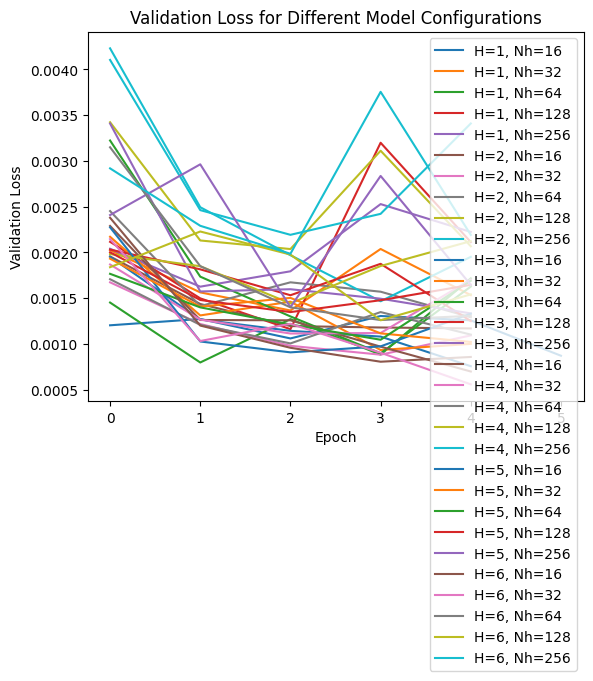

Model with H=1 and Nh=16:
MSE: 0.001206291955895722
MAE: 0.0012062915036005696
RMSE: 0.0026695012812500305
R-squared: 0.9495541741780332
MAPE: 6.144476606695855%
Model with H=1 and Nh=32:
MSE: 0.002024922287091613
MAE: 0.002024923063291578
RMSE: 0.0036091539216682126
R-squared: 0.9558396042355732
MAPE: 7.014056318366759%
Model with H=1 and Nh=64:
MSE: 0.0014655794948339462
MAE: 0.0014655800730307917
RMSE: 0.0029106934604854555
R-squared: 0.9684373232884653
MAPE: 5.641157478530215%
Model with H=1 and Nh=128:
MSE: 0.0021197404712438583
MAE: 0.0021197403042265187
RMSE: 0.003473977192124645
R-squared: 0.9447064354174579
MAPE: 8.876244984772388%
Model with H=1 and Nh=256:
MSE: 0.0020582820288836956
MAE: 0.002058282504527292
RMSE: 0.0035835316916813438
R-squared: 0.9301432030184933
MAPE: 8.435184285350736%
Model with H=2 and Nh=16:
MSE: 0.001970144920051098
MAE: 0.0019701440366002173
RMSE: 0.0037570056594519803
R-squared: 0.916349401986053
MAPE: 10.044540756120377%
Model with H=2 and Nh=32:


In [34]:
# Load your simulation data
df_conduction_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_conduction_loss = df_conduction_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_ON_H, P_ON_L)
y_conduction_loss = df_conduction_loss[['P_ON_H', 'P_ON_L']].values  # Adjusted column names

X_scaled_conduction_loss = custom_scaling(X_conduction_loss)

# Split the dataset into training, validation, and testing sets
X_train_conduction_loss, X_temp_conduction_loss, y_train_conduction_loss, y_temp_conduction_loss = train_test_split(X_scaled_conduction_loss, y_conduction_loss, test_size=0.3, random_state=42)
X_val_conduction_loss, X_test_conduction_loss, y_val_conduction_loss, y_test_conduction_loss = train_test_split(X_temp_conduction_loss, y_temp_conduction_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_conduction_loss = {}
maes_conduction_loss = {}
rmses_conduction_loss = {}
r2_scores_conduction_loss = {}
mapes_conduction_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_conduction_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_conduction_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_conduction_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_conduction_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_conduction_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_conduction_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_conduction_loss.add(tf.keras.layers.Dense(2, activation='softplus'))  

        # Compile the model
        model_conduction_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_conduction_loss = model_conduction_loss.fit(X_train_conduction_loss, y_train_conduction_loss, epochs=100, batch_size=32, validation_data=(X_val_conduction_loss, y_val_conduction_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_conduction_loss[(H, Nh)] = history_conduction_loss

        # Evaluate the model on the testing set
        predictions_conduction_loss = model_conduction_loss.predict(X_test_conduction_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_conduction_loss = model_conduction_loss.evaluate(X_test_conduction_loss, y_test_conduction_loss, verbose=0)
        mses_conduction_loss[(H, Nh)] = mse_conduction_loss

        # Calculate Mean Absolute Error (MAE)
        mae_conduction_loss = mean_absolute_error(y_test_conduction_loss, predictions_conduction_loss)
        maes_conduction_loss[(H, Nh)] = mae_conduction_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_conduction_loss = np.sqrt(mean_squared_error(y_test_conduction_loss, predictions_conduction_loss))
        rmses_conduction_loss[(H, Nh)] = rmse_conduction_loss

        # Calculate R-squared (R2) Score
        r2_conduction_loss = r2_score(y_test_conduction_loss, predictions_conduction_loss)
        r2_scores_conduction_loss[(H, Nh)] = r2_conduction_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_conduction_loss = np.mean(np.abs((y_test_conduction_loss - predictions_conduction_loss) / y_test_conduction_loss)) * 100
        mapes_conduction_loss[(H, Nh)] = mape_conduction_loss

# Plot the validation loss for each configuration
for (H, Nh), history_conduction_loss in histories_conduction_loss.items():
    plt.plot(history_conduction_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_conduction_loss in mses_conduction_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_conduction_loss}')
    print(f'MAE: {maes_conduction_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_conduction_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_conduction_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_conduction_loss[(H, Nh)]}%')


In [36]:
# Rank combinations based on their MSE values
ranked_combinations_conduction_loss = sorted(mses_conduction_loss.items(), key=lambda x: x[1])
# Print ranked combinations
for idx, ((H, Nh), mse_conduction_loss) in enumerate(ranked_combinations_conduction_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_conduction_loss}")


Rank 1: Combination H=1, Nh=16 - MSE: 0.001206291955895722
Rank 2: Combination H=1, Nh=64 - MSE: 0.0014655794948339462
Rank 3: Combination H=2, Nh=32 - MSE: 0.0016737354453653097
Rank 4: Combination H=4, Nh=64 - MSE: 0.0017134584486484528
Rank 5: Combination H=5, Nh=64 - MSE: 0.001777543337084353
Rank 6: Combination H=4, Nh=32 - MSE: 0.0018845003796741366
Rank 7: Combination H=6, Nh=128 - MSE: 0.0018974626436829567
Rank 8: Combination H=5, Nh=32 - MSE: 0.0019321390427649021
Rank 9: Combination H=2, Nh=16 - MSE: 0.001970144920051098
Rank 10: Combination H=4, Nh=128 - MSE: 0.0019712955690920353
Rank 11: Combination H=3, Nh=16 - MSE: 0.0019755475223064423
Rank 12: Combination H=5, Nh=128 - MSE: 0.001993431942537427
Rank 13: Combination H=1, Nh=32 - MSE: 0.002024922287091613
Rank 14: Combination H=1, Nh=256 - MSE: 0.0020582820288836956
Rank 15: Combination H=3, Nh=128 - MSE: 0.0020687461365014315
Rank 16: Combination H=1, Nh=128 - MSE: 0.0021197404712438583
Rank 17: Combination H=6, Nh=32 

In [73]:
# Specify the combination you want to call
H = 1
Nh = 16

# Retrieve the model for the specified combination
selected_model_conduction_loss = histories_conduction_loss[(H, Nh)].model
selected_model_conduction_loss.save("P_ON_H_P_ON_L.h5")

# Use the trained model to make predictions on the testing set
predictions_conduction_loss = selected_model_conduction_loss.predict(X_test_conduction_loss)

# Evaluate the model on the testing set
mse_conduction_loss = selected_model_conduction_loss.evaluate(X_test_conduction_loss, y_test_conduction_loss)
print("Mean Squared Error on Testing Set:", mse_conduction_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_conduction_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_conduction_loss[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 313us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 302us/step - loss: 0.0012
Mean Squared Error on Testing Set: 0.001206291955895722
Predictions:
[[0.00146487 0.03106316]
 [0.00261739 0.04213859]
 [0.00315243 0.04612676]
 [0.00196772 0.03452742]
 [0.00773761 0.08422849]]
True Values:
[[0.00151069 0.02935826]
 [0.00280825 0.04386154]
 [0.00292383 0.0449992 ]
 [0.00185468 0.03358003]
 [0.00771341 0.08379952]]


## P_COSS

Epoch 5/100, Loss: 0.005566186271607876, Val Loss: 0.0025648039299994707
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 766us/step


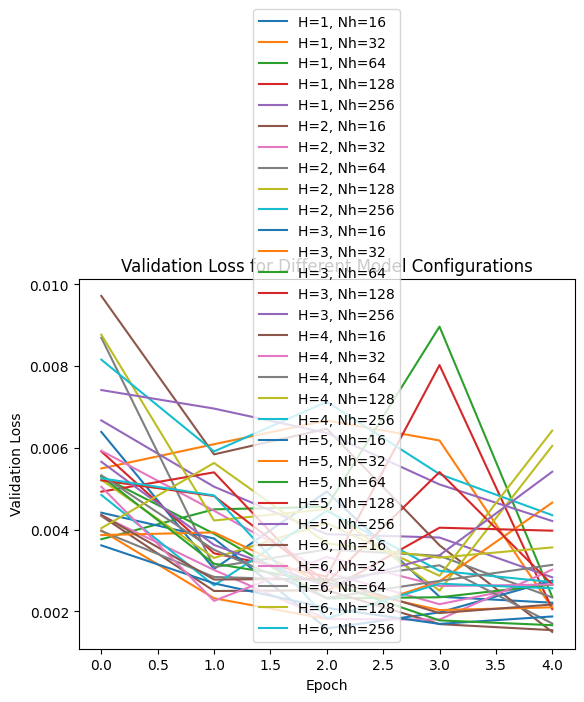

Model with H=1 and Nh=16:
MSE: 0.006368180736899376
MAE: 0.006368184220061297
RMSE: 0.007360939975135297
R-squared: 0.957410135506578
MAPE: 18.21827457250237%
Model with H=1 and Nh=32:
MSE: 0.005481637082993984
MAE: 0.005481638444315354
RMSE: 0.006386282587922128
R-squared: 0.9679420336022962
MAPE: 10.723650780298877%
Model with H=1 and Nh=64:
MSE: 0.0037048254162073135
MAE: 0.003704826639710063
RMSE: 0.004661993340075326
R-squared: 0.9829162580311152
MAPE: 8.724867458928165%
Model with H=1 and Nh=128:
MSE: 0.005844505969434977
MAE: 0.005844506570663729
RMSE: 0.007842073860610902
R-squared: 0.9516605658336444
MAPE: 10.25258776486169%
Model with H=1 and Nh=256:
MSE: 0.006637288723140955
MAE: 0.006637288139573636
RMSE: 0.008965080169265253
R-squared: 0.936824591206871
MAPE: 10.170143759927699%
Model with H=2 and Nh=16:
MSE: 0.00963698048144579
MAE: 0.009636982772851459
RMSE: 0.012137459379468305
R-squared: 0.8842035395152312
MAPE: 17.30600182702953%
Model with H=2 and Nh=32:
MSE: 0.00586

In [38]:
# Load your simulation data
df_out_cap_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_out_cap_loss = df_out_cap_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_COSS)
y_out_cap_loss = df_out_cap_loss[['P_COSS']].values  # Adjusted column names

X_scaled_out_cap_loss = custom_scaling(X_out_cap_loss)

# Split the dataset into training, validation, and testing sets
X_train_out_cap_loss, X_temp_out_cap_loss, y_train_out_cap_loss, y_temp_out_cap_loss = train_test_split(X_scaled_out_cap_loss, y_out_cap_loss, test_size=0.3, random_state=42)
X_val_out_cap_loss, X_test_out_cap_loss, y_val_out_cap_loss, y_test_out_cap_loss = train_test_split(X_temp_out_cap_loss, y_temp_out_cap_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_out_cap_loss = {}
maes_out_cap_loss = {}
rmses_out_cap_loss = {}
r2_scores_out_cap_loss = {}
mapes_out_cap_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_out_cap_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_out_cap_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_out_cap_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_out_cap_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_out_cap_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_out_cap_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_out_cap_loss.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_out_cap_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_out_cap_loss = model_out_cap_loss.fit(X_train_out_cap_loss, y_train_out_cap_loss, epochs=100, batch_size=32, validation_data=(X_val_out_cap_loss, y_val_out_cap_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_out_cap_loss[(H, Nh)] = history_out_cap_loss

        # Evaluate the model on the testing set
        predictions_out_cap_loss = model_out_cap_loss.predict(X_test_out_cap_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_out_cap_loss = model_out_cap_loss.evaluate(X_test_out_cap_loss, y_test_out_cap_loss, verbose=0)
        mses_out_cap_loss[(H, Nh)] = mse_out_cap_loss

        # Calculate Mean Absolute Error (MAE)
        mae_out_cap_loss = mean_absolute_error(y_test_out_cap_loss, predictions_out_cap_loss)
        maes_out_cap_loss[(H, Nh)] = mae_out_cap_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_out_cap_loss = np.sqrt(mean_squared_error(y_test_out_cap_loss, predictions_out_cap_loss))
        rmses_out_cap_loss[(H, Nh)] = rmse_out_cap_loss

        # Calculate R-squared (R2) Score
        r2_out_cap_loss = r2_score(y_test_out_cap_loss, predictions_out_cap_loss)
        r2_scores_out_cap_loss[(H, Nh)] = r2_out_cap_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_out_cap_loss = np.mean(np.abs((y_test_out_cap_loss - predictions_out_cap_loss) / y_test_out_cap_loss)) * 100
        mapes_out_cap_loss[(H, Nh)] = mape_out_cap_loss

# Plot the validation loss for each configuration
for (H, Nh), history_out_cap_loss in histories_out_cap_loss.items():
    plt.plot(history_out_cap_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_out_cap_loss in mses_out_cap_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_out_cap_loss}')
    print(f'MAE: {maes_out_cap_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_out_cap_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_out_cap_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_out_cap_loss[(H, Nh)]}%')


In [40]:
# Rank combinations based on their MSE values
ranked_combinations_out_cap_loss = sorted(mses_out_cap_loss.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_out_cap_loss) in enumerate(ranked_combinations_out_cap_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_out_cap_loss}")


Rank 1: Combination H=5, Nh=16 - MSE: 0.003569280728697777
Rank 2: Combination H=1, Nh=64 - MSE: 0.0037048254162073135
Rank 3: Combination H=5, Nh=32 - MSE: 0.003838431788608432
Rank 4: Combination H=3, Nh=32 - MSE: 0.003905115183442831
Rank 5: Combination H=4, Nh=64 - MSE: 0.0039271023124456406
Rank 6: Combination H=6, Nh=128 - MSE: 0.004003675188869238
Rank 7: Combination H=4, Nh=16 - MSE: 0.004334763623774052
Rank 8: Combination H=3, Nh=16 - MSE: 0.004352294374257326
Rank 9: Combination H=4, Nh=32 - MSE: 0.00436787586659193
Rank 10: Combination H=6, Nh=16 - MSE: 0.004380307160317898
Rank 11: Combination H=4, Nh=256 - MSE: 0.00484264874830842
Rank 12: Combination H=3, Nh=128 - MSE: 0.004912937991321087
Rank 13: Combination H=6, Nh=32 - MSE: 0.005002251826226711
Rank 14: Combination H=6, Nh=256 - MSE: 0.005177146755158901
Rank 15: Combination H=5, Nh=128 - MSE: 0.005188976880162954
Rank 16: Combination H=4, Nh=128 - MSE: 0.005202554631978273
Rank 17: Combination H=5, Nh=64 - MSE: 0.00

In [74]:
# Specify the combination you want to call
H = 5
Nh = 16

# Retrieve the model for the specified combination
selected_model_out_cap_loss = histories_out_cap_loss[(H, Nh)].model
selected_model_out_cap_loss.save("P_COSS.h5")

# Use the trained model to make predictions on the testing set
predictions_out_cap_loss = selected_model_out_cap_loss.predict(X_test_out_cap_loss)

# Evaluate the model on the testing set
mse_out_cap_loss = selected_model_out_cap_loss.evaluate(X_test_out_cap_loss, y_test_out_cap_loss)
print("Mean Squared Error on Testing Set:", mse_out_cap_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_out_cap_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_out_cap_loss[:5])

469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 469us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step - loss: 0.0036
Mean Squared Error on Testing Set: 0.003569280728697777
Predictions:
[[0.0603058 ]
 [0.02483669]
 [0.02164658]
 [0.06066547]
 [0.07077333]]
True Values:
[[0.062208 ]
 [0.0248832]
 [0.0248832]
 [0.062208 ]
 [0.0746496]]


## P_L_DCR

Epoch 5/100, Loss: 1.869868278503418, Val Loss: 0.747521698474884
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 784us/step


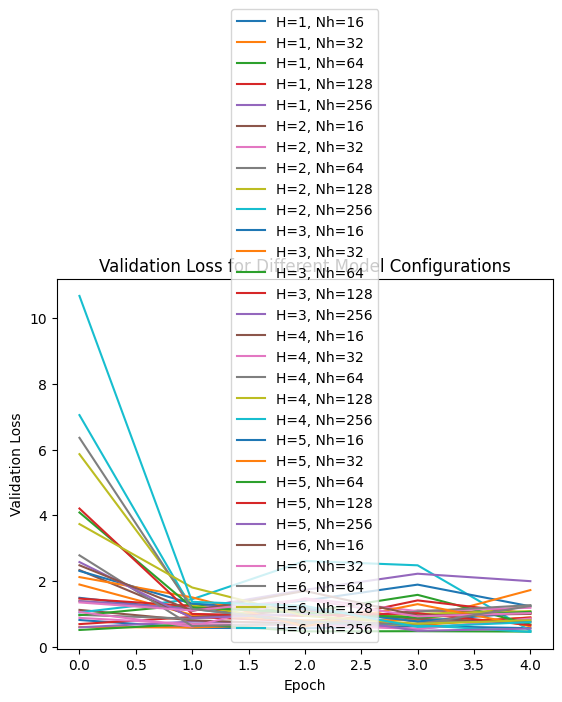

Model with H=1 and Nh=16:
MSE: 0.829692006111145
MAE: 0.8296919482225796
RMSE: 1.7354254674215246
R-squared: 0.9770074559733284
MAPE: 3.0840071132333726%
Model with H=1 and Nh=32:
MSE: 0.6166291832923889
MAE: 0.6166295611595957
RMSE: 1.5841323034108485
R-squared: 0.9808416548042409
MAPE: 2.262409459611093%
Model with H=1 and Nh=64:
MSE: 0.5215254426002502
MAE: 0.521525346977442
RMSE: 1.5124613490249832
R-squared: 0.9825360023610027
MAPE: 1.7888349802522856%
Model with H=1 and Nh=128:
MSE: 0.6930151581764221
MAE: 0.6930151226391807
RMSE: 1.3908478221064626
R-squared: 0.9852315701835556
MAPE: 2.155331739637476%
Model with H=1 and Nh=256:
MSE: 0.5970611572265625
MAE: 0.5970611322523821
RMSE: 1.4070899154669116
R-squared: 0.9848846295699193
MAPE: 2.167404784756714%
Model with H=2 and Nh=16:
MSE: 1.1563931703567505
MAE: 1.1563933061523486
RMSE: 2.2769196441713064
R-squared: 0.9604204819273009
MAPE: 5.145884275718763%
Model with H=2 and Nh=32:
MSE: 0.8873267769813538
MAE: 0.8873267744701586


In [42]:
# Load your simulation data
df_ind_cond_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_ind_cond_loss = df_ind_cond_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_COSS)
y_ind_cond_loss = df_ind_cond_loss[['P_L_DCR']].values  # Adjusted column names

X_scaled_ind_cond_loss = custom_scaling(X_ind_cond_loss)

# Split the dataset into training, validation, and testing sets
X_train_ind_cond_loss, X_temp_ind_cond_loss, y_train_ind_cond_loss, y_temp_ind_cond_loss = train_test_split(X_scaled_ind_cond_loss, y_ind_cond_loss, test_size=0.3, random_state=42)
X_val_ind_cond_loss, X_test_ind_cond_loss, y_val_ind_cond_loss, y_test_ind_cond_loss = train_test_split(X_temp_ind_cond_loss, y_temp_ind_cond_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_ind_cond_loss = {}
maes_ind_cond_loss = {}
rmses_ind_cond_loss = {}
r2_scores_ind_cond_loss = {}
mapes_ind_cond_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_ind_cond_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_ind_cond_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_ind_cond_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_ind_cond_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_ind_cond_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_ind_cond_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_ind_cond_loss.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_ind_cond_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_ind_cond_loss = model_ind_cond_loss.fit(X_train_ind_cond_loss, y_train_ind_cond_loss, epochs=100, batch_size=32, validation_data=(X_val_ind_cond_loss, y_val_ind_cond_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_ind_cond_loss[(H, Nh)] = history_ind_cond_loss

        # Evaluate the model on the testing set
        predictions_ind_cond_loss = model_ind_cond_loss.predict(X_test_ind_cond_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_ind_cond_loss = model_ind_cond_loss.evaluate(X_test_ind_cond_loss, y_test_ind_cond_loss, verbose=0)
        mses_ind_cond_loss[(H, Nh)] = mse_ind_cond_loss

        # Calculate Mean Absolute Error (MAE)
        mae_ind_cond_loss = mean_absolute_error(y_test_ind_cond_loss, predictions_ind_cond_loss)
        maes_ind_cond_loss[(H, Nh)] = mae_ind_cond_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_ind_cond_loss = np.sqrt(mean_squared_error(y_test_ind_cond_loss, predictions_ind_cond_loss))
        rmses_ind_cond_loss[(H, Nh)] = rmse_ind_cond_loss

        # Calculate R-squared (R2) Score
        r2_ind_cond_loss = r2_score(y_test_ind_cond_loss, predictions_ind_cond_loss)
        r2_scores_ind_cond_loss[(H, Nh)] = r2_ind_cond_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_ind_cond_loss = np.mean(np.abs((y_test_ind_cond_loss - predictions_ind_cond_loss) / y_test_ind_cond_loss)) * 100
        mapes_ind_cond_loss[(H, Nh)] = mape_ind_cond_loss

# Plot the validation loss for each configuration
for (H, Nh), history_ind_cond_loss in histories_ind_cond_loss.items():
    plt.plot(history_ind_cond_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_ind_cond_loss in mses_ind_cond_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_ind_cond_loss}')
    print(f'MAE: {maes_ind_cond_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_ind_cond_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_ind_cond_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_ind_cond_loss[(H, Nh)]}%')


In [43]:
# Rank combinations based on their MSE values
ranked_combinations_ind_cond_loss = sorted(mses_ind_cond_loss.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_ind_cond_loss) in enumerate(ranked_combinations_ind_cond_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_ind_cond_loss}")


Rank 1: Combination H=1, Nh=64 - MSE: 0.5215254426002502
Rank 2: Combination H=1, Nh=256 - MSE: 0.5970611572265625
Rank 3: Combination H=1, Nh=32 - MSE: 0.6166291832923889
Rank 4: Combination H=1, Nh=128 - MSE: 0.6930151581764221
Rank 5: Combination H=1, Nh=16 - MSE: 0.829692006111145
Rank 6: Combination H=2, Nh=32 - MSE: 0.8873267769813538
Rank 7: Combination H=3, Nh=64 - MSE: 0.9686794281005859
Rank 8: Combination H=2, Nh=64 - MSE: 0.9967038035392761
Rank 9: Combination H=2, Nh=256 - MSE: 1.0442043542861938
Rank 10: Combination H=4, Nh=32 - MSE: 1.0459611415863037
Rank 11: Combination H=2, Nh=16 - MSE: 1.1563931703567505
Rank 12: Combination H=6, Nh=32 - MSE: 1.3615496158599854
Rank 13: Combination H=2, Nh=128 - MSE: 1.3942961692810059
Rank 14: Combination H=3, Nh=256 - MSE: 1.418297290802002
Rank 15: Combination H=3, Nh=128 - MSE: 1.4821146726608276
Rank 16: Combination H=3, Nh=16 - MSE: 1.5020071268081665
Rank 17: Combination H=3, Nh=32 - MSE: 1.8771896362304688
Rank 18: Combinatio

In [75]:
# Specify the combination you want to call
H = 1
Nh = 64

# Retrieve the model for the specified combination
selected_model_ind_cond_loss = histories_ind_cond_loss[(H, Nh)].model
selected_model_ind_cond_loss.save("P_L_DCR.h5")

# Use the trained model to make predictions on the testing set
predictions_ind_cond_loss = selected_model_ind_cond_loss.predict(X_test_ind_cond_loss)

# Evaluate the model on the testing set
mse_ind_cond_loss = selected_model_ind_cond_loss.evaluate(X_test_ind_cond_loss, y_test_ind_cond_loss)
print("Mean Squared Error on Testing Set:", mse_ind_cond_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_ind_cond_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_ind_cond_loss[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 339us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 312us/step - loss: 0.5327
Mean Squared Error on Testing Set: 0.5215254426002502
Predictions:
[[15.046248]
 [22.255325]
 [23.351688]
 [17.541044]
 [44.40175 ]]
True Values:
[[14.90118391]
 [22.52862872]
 [23.13359815]
 [17.10518567]
 [44.17548684]]


## P_D

Epoch 5/100, Loss: 0.005355357192456722, Val Loss: 0.003103853901848197
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 853us/step


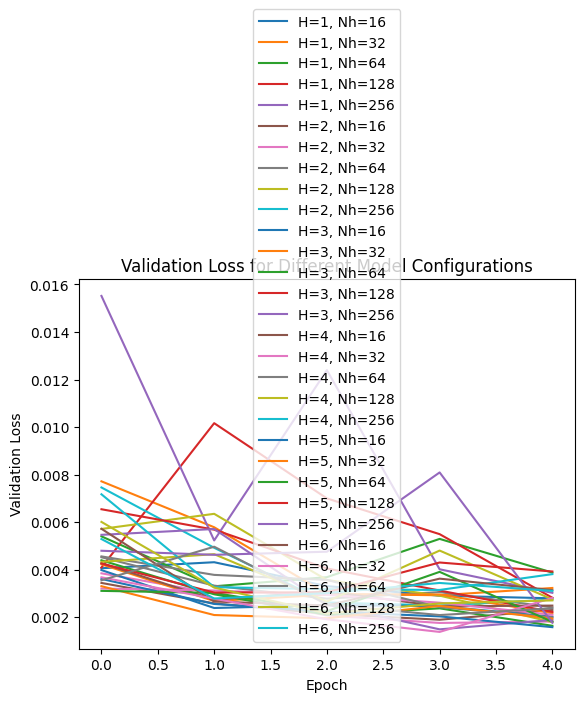

Model with H=1 and Nh=16:
MSE: 0.004084940534085035
MAE: 0.004084939618066697
RMSE: 0.005042602515077144
R-squared: 0.9695939105954613
MAPE: 13.663734322366732%
Model with H=1 and Nh=32:
MSE: 0.0076338243670761585
MAE: 0.007633821355606441
RMSE: 0.009094992556307887
R-squared: 0.9010864493315203
MAPE: 20.313039108989592%
Model with H=1 and Nh=64:
MSE: 0.005309553351253271
MAE: 0.005309552298142995
RMSE: 0.007111976552754276
R-squared: 0.9395172222807067
MAPE: 12.771854339921543%
Model with H=1 and Nh=128:
MSE: 0.004049996379762888
MAE: 0.004049997272809571
RMSE: 0.005473109615081154
R-squared: 0.9641805107903633
MAPE: 10.220803983294637%
Model with H=1 and Nh=256:
MSE: 0.015375226736068726
MAE: 0.015375219220587112
RMSE: 0.021031272247690316
R-squared: 0.4710895026522113
MAPE: 25.335226177844522%
Model with H=2 and Nh=16:
MSE: 0.003445293754339218
MAE: 0.003445294005624744
RMSE: 0.004519519368499945
R-squared: 0.9755749422186228
MAPE: 9.617808789189617%
Model with H=2 and Nh=32:
MSE: 0

In [45]:
# Load your simulation data
df_dead_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_dead_loss = df_dead_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_D)
y_dead_loss = df_dead_loss[['P_D']].values  # Adjusted column names

X_scaled_dead_loss = custom_scaling(X_dead_loss)

# Split the dataset into training, validation, and testing sets
X_train_dead_loss, X_temp_dead_loss, y_train_dead_loss, y_temp_dead_loss = train_test_split(X_scaled_dead_loss, y_dead_loss, test_size=0.3, random_state=42)
X_val_dead_loss, X_test_dead_loss, y_val_dead_loss, y_test_dead_loss = train_test_split(X_temp_dead_loss, y_temp_dead_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_dead_loss = {}
maes_dead_loss = {}
rmses_dead_loss = {}
r2_scores_dead_loss = {}
mapes_dead_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_dead_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_dead_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_dead_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_dead_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_dead_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_dead_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_dead_loss.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_dead_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_dead_loss = model_dead_loss.fit(X_train_dead_loss, y_train_dead_loss, epochs=100, batch_size=32, validation_data=(X_val_dead_loss, y_val_dead_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_dead_loss[(H, Nh)] = history_dead_loss

        # Evaluate the model on the testing set
        predictions_dead_loss = model_dead_loss.predict(X_test_dead_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_dead_loss = model_dead_loss.evaluate(X_test_dead_loss, y_test_dead_loss, verbose=0)
        mses_dead_loss[(H, Nh)] = mse_dead_loss

        # Calculate Mean Absolute Error (MAE)
        mae_dead_loss = mean_absolute_error(y_test_dead_loss, predictions_dead_loss)
        maes_dead_loss[(H, Nh)] = mae_dead_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_dead_loss = np.sqrt(mean_squared_error(y_test_dead_loss, predictions_dead_loss))
        rmses_dead_loss[(H, Nh)] = rmse_dead_loss

        # Calculate R-squared (R2) Score
        r2_dead_loss = r2_score(y_test_dead_loss, predictions_dead_loss)
        r2_scores_dead_loss[(H, Nh)] = r2_dead_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_dead_loss = np.mean(np.abs((y_test_dead_loss - predictions_dead_loss) / y_test_dead_loss)) * 100
        mapes_dead_loss[(H, Nh)] = mape_dead_loss

# Plot the validation loss for each configuration
for (H, Nh), history_dead_loss in histories_dead_loss.items():
    plt.plot(history_dead_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_dead_loss in mses_dead_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_dead_loss}')
    print(f'MAE: {maes_dead_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_dead_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_dead_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_dead_loss[(H, Nh)]}%')


In [46]:
# Rank combinations based on their MSE values
ranked_combinations_dead_loss = sorted(mses_dead_loss.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_dead_loss) in enumerate(ranked_combinations_dead_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_dead_loss}")


Rank 1: Combination H=5, Nh=64 - MSE: 0.003034354653209448
Rank 2: Combination H=4, Nh=32 - MSE: 0.003146737115457654
Rank 3: Combination H=5, Nh=32 - MSE: 0.0032347592059522867
Rank 4: Combination H=2, Nh=16 - MSE: 0.003445293754339218
Rank 5: Combination H=6, Nh=64 - MSE: 0.0034984429366886616
Rank 6: Combination H=5, Nh=16 - MSE: 0.0036100982688367367
Rank 7: Combination H=6, Nh=32 - MSE: 0.0036509463097900152
Rank 8: Combination H=2, Nh=32 - MSE: 0.003889034502208233
Rank 9: Combination H=3, Nh=16 - MSE: 0.0040274267084896564
Rank 10: Combination H=1, Nh=128 - MSE: 0.004049996379762888
Rank 11: Combination H=1, Nh=16 - MSE: 0.004084940534085035
Rank 12: Combination H=3, Nh=32 - MSE: 0.004186773672699928
Rank 13: Combination H=5, Nh=128 - MSE: 0.0042055645026266575
Rank 14: Combination H=4, Nh=16 - MSE: 0.004253873601555824
Rank 15: Combination H=4, Nh=128 - MSE: 0.004346691071987152
Rank 16: Combination H=3, Nh=64 - MSE: 0.0044062789529562
Rank 17: Combination H=2, Nh=64 - MSE: 0.0

In [76]:
# Specify the combination you want to call
H = 5
Nh = 64

# Retrieve the model for the specified combination
selected_model_dead_loss = histories_dead_loss[(H, Nh)].model
selected_model_dead_loss.save("P_D.h5")

# Use the trained model to make predictions on the testing set
predictions_dead_loss = selected_model_dead_loss.predict(X_test_dead_loss)

# Evaluate the model on the testing set
mse_dead_loss = selected_model_dead_loss.evaluate(X_test_dead_loss, y_test_dead_loss)
print("Mean Squared Error on Testing Set:", mse_dead_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_dead_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_dead_loss[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 401us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - loss: 0.0030
Mean Squared Error on Testing Set: 0.003034354653209448
Predictions:
[[0.03410102]
 [0.02127623]
 [0.01291968]
 [0.04026149]
 [0.06065822]]
True Values:
[[0.03038798]
 [0.02045851]
 [0.01435061]
 [0.03942508]
 [0.05949228]]


## P_G

Epoch 5/100, Loss: 0.02169014886021614, Val Loss: 0.01350997295230627
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 819us/step


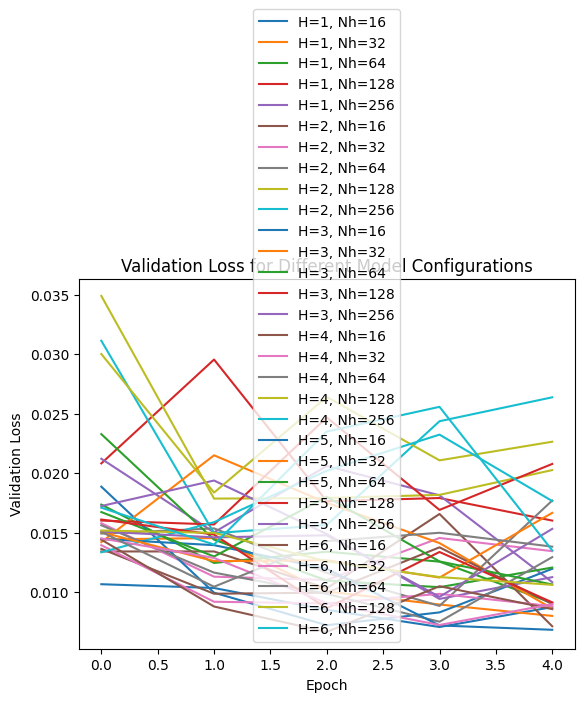

Model with H=1 and Nh=16:
MSE: 0.01064753532409668
MAE: 0.010647545742605126
RMSE: 0.013339886886717544
R-squared: 0.9953174907539779
MAPE: 4.5780042499166225%
Model with H=1 and Nh=32:
MSE: 0.014541693031787872
MAE: 0.014541692332494256
RMSE: 0.018405334166253316
R-squared: 0.9910862230353449
MAPE: 6.5110171540154%
Model with H=1 and Nh=64:
MSE: 0.017431966960430145
MAE: 0.017431969330016818
RMSE: 0.021984928058578528
R-squared: 0.987281835232749
MAPE: 6.580724299996797%
Model with H=1 and Nh=128:
MSE: 0.020767977461218834
MAE: 0.020767973816416704
RMSE: 0.02550810615159324
R-squared: 0.9828789348167153
MAPE: 9.380745802256833%
Model with H=1 and Nh=256:
MSE: 0.02083706110715866
MAE: 0.020837057323433966
RMSE: 0.026307107089520526
R-squared: 0.9817895559941323
MAPE: 7.883669982430813%
Model with H=2 and Nh=16:
MSE: 0.01338692381978035
MAE: 0.013386924348217262
RMSE: 0.017084432440303388
R-squared: 0.9923197481619499
MAPE: 5.8497413256606485%
Model with H=2 and Nh=32:
MSE: 0.0158373955

In [48]:
# Load your simulation data
df_gate_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_gate_loss = df_gate_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_G)
y_gate_loss = df_gate_loss[['P_G']].values  # Adjusted column names

X_scaled_gate_loss = custom_scaling(X_gate_loss)

# Split the dataset into training, validation, and testing sets
X_train_gate_loss, X_temp_gate_loss, y_train_gate_loss, y_temp_gate_loss = train_test_split(X_scaled_gate_loss, y_gate_loss, test_size=0.3, random_state=42)
X_val_gate_loss, X_test_gate_loss, y_val_gate_loss, y_test_gate_loss = train_test_split(X_temp_gate_loss, y_temp_gate_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_gate_loss = {}
maes_gate_loss = {}
rmses_gate_loss = {}
r2_scores_gate_loss = {}
mapes_gate_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_gate_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_gate_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_gate_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_gate_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_gate_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_gate_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_gate_loss.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_gate_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_gate_loss = model_gate_loss.fit(X_train_gate_loss, y_train_gate_loss, epochs=100, batch_size=32, validation_data=(X_val_gate_loss, y_val_gate_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_gate_loss[(H, Nh)] = history_gate_loss

        # Evaluate the model on the testing set
        predictions_gate_loss = model_gate_loss.predict(X_test_gate_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_gate_loss = model_gate_loss.evaluate(X_test_gate_loss, y_test_gate_loss, verbose=0)
        mses_gate_loss[(H, Nh)] = mse_gate_loss

        # Calculate Mean Absolute Error (MAE)
        mae_gate_loss = mean_absolute_error(y_test_gate_loss, predictions_gate_loss)
        maes_gate_loss[(H, Nh)] = mae_gate_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_gate_loss = np.sqrt(mean_squared_error(y_test_gate_loss, predictions_gate_loss))
        rmses_gate_loss[(H, Nh)] = rmse_gate_loss

        # Calculate R-squared (R2) Score
        r2_gate_loss = r2_score(y_test_gate_loss, predictions_gate_loss)
        r2_scores_gate_loss[(H, Nh)] = r2_gate_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_gate_loss = np.mean(np.abs((y_test_gate_loss - predictions_gate_loss) / y_test_gate_loss)) * 100
        mapes_gate_loss[(H, Nh)] = mape_gate_loss

# Plot the validation loss for each configuration
for (H, Nh), history_gate_loss in histories_gate_loss.items():
    plt.plot(history_gate_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_gate_loss in mses_gate_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_gate_loss}')
    print(f'MAE: {maes_gate_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_gate_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_gate_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_gate_loss[(H, Nh)]}%')


In [50]:
# Rank combinations based on their MSE values
ranked_combinations_gate_loss = sorted(mses_gate_loss.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_gate_loss) in enumerate(ranked_combinations_gate_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_gate_loss}")


Rank 1: Combination H=1, Nh=16 - MSE: 0.01064753532409668
Rank 2: Combination H=4, Nh=256 - MSE: 0.013313292525708675
Rank 3: Combination H=2, Nh=16 - MSE: 0.01338692381978035
Rank 4: Combination H=4, Nh=16 - MSE: 0.013840897008776665
Rank 5: Combination H=4, Nh=32 - MSE: 0.014075647108256817
Rank 6: Combination H=3, Nh=32 - MSE: 0.014184716157615185
Rank 7: Combination H=5, Nh=16 - MSE: 0.014390680007636547
Rank 8: Combination H=1, Nh=32 - MSE: 0.014541693031787872
Rank 9: Combination H=6, Nh=32 - MSE: 0.01454995758831501
Rank 10: Combination H=6, Nh=16 - MSE: 0.014584075659513474
Rank 11: Combination H=6, Nh=64 - MSE: 0.015028917230665684
Rank 12: Combination H=2, Nh=64 - MSE: 0.015112106688320637
Rank 13: Combination H=6, Nh=128 - MSE: 0.01514482218772173
Rank 14: Combination H=5, Nh=256 - MSE: 0.01517897192388773
Rank 15: Combination H=5, Nh=32 - MSE: 0.01524294726550579
Rank 16: Combination H=4, Nh=64 - MSE: 0.01569831557571888
Rank 17: Combination H=2, Nh=32 - MSE: 0.015837395563

In [77]:
# Specify the combination you want to call
H = 1
Nh = 16

# Retrieve the model for the specified combination
selected_model_gate_loss = histories_gate_loss[(H, Nh)].model
selected_model_gate_loss.save("P_G.h5")

# Use the trained model to make predictions on the testing set
predictions_gate_loss = selected_model_gate_loss.predict(X_test_gate_loss)

# Evaluate the model on the testing set
mse_gate_loss = selected_model_gate_loss.evaluate(X_test_gate_loss, y_test_gate_loss)
print("Mean Squared Error on Testing Set:", mse_gate_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_gate_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_gate_loss[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 322us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 289us/step - loss: 0.0105
Mean Squared Error on Testing Set: 0.01064753532409668
Predictions:
[[0.3410325 ]
 [0.13072991]
 [0.13182683]
 [0.32964548]
 [0.39830598]]
True Values:
[[0.34 ]
 [0.136]
 [0.136]
 [0.34 ]
 [0.408]]


## P_CAP_ESR

Epoch 5/100, Loss: 0.02420356310904026, Val Loss: 0.013929186388850212
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 1.
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 883us/step


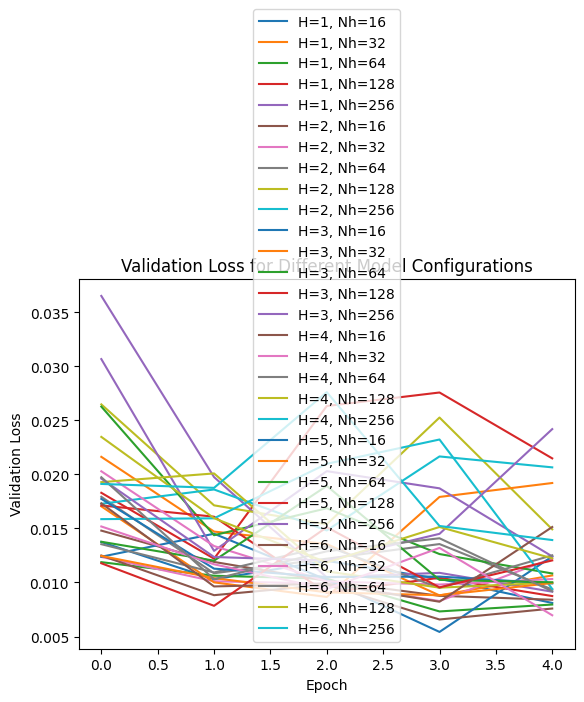

Model with H=1 and Nh=16:
MSE: 0.013916379772126675
MAE: 0.013916380383932635
RMSE: 0.018342256107587544
R-squared: 0.991147216251422
MAPE: 5.892764747472705%
Model with H=1 and Nh=32:
MSE: 0.02152175083756447
MAE: 0.021521757801878417
RMSE: 0.025256942241623854
R-squared: 0.9832144378023174
MAPE: 7.268364754423683%
Model with H=1 and Nh=64:
MSE: 0.011994055472314358
MAE: 0.0119940619767825
RMSE: 0.01501655121958377
R-squared: 0.9940664479970035
MAPE: 5.428982692049521%
Model with H=1 and Nh=128:
MSE: 0.018185658380389214
MAE: 0.018185668015539686
RMSE: 0.02127908261388288
R-squared: 0.9880853812313279
MAPE: 8.060173296936323%
Model with H=1 and Nh=256:
MSE: 0.036392081528902054
MAE: 0.03639209677546425
RMSE: 0.044146449032251
R-squared: 0.9487178880762611
MAPE: 14.042028595914285%
Model with H=2 and Nh=16:
MSE: 0.014678621664643288
MAE: 0.014678616299732522
RMSE: 0.018394437788004772
R-squared: 0.9910967742302963
MAPE: 5.610399926254687%
Model with H=2 and Nh=32:
MSE: 0.01235458999872

In [52]:
# Load your simulation data
df_cap_loss = pd.read_csv(csv_file_path)

# Extract input features (L, C, fsw, t_d, d_cycle)
X_cap_loss = df_cap_loss[['L', 'C', 'fsw', 't_d', 'd_cycle']].values

# Extract output (P_G)
y_cap_loss = df_cap_loss[['P_G']].values  # Adjusted column names

X_scaled_cap_loss = custom_scaling(X_cap_loss)

# Split the dataset into training, validation, and testing sets
X_train_cap_loss, X_temp_cap_loss, y_train_cap_loss, y_temp_cap_loss = train_test_split(X_scaled_cap_loss, y_cap_loss, test_size=0.3, random_state=42)
X_val_cap_loss, X_test_cap_loss, y_val_cap_loss, y_test_cap_loss = train_test_split(X_temp_cap_loss, y_temp_cap_loss, test_size=0.5, random_state=42)

# Initialize dictionaries to store the evaluation metrics for each configuration
mses_cap_loss = {}
maes_cap_loss = {}
rmses_cap_loss = {}
r2_scores_cap_loss = {}
mapes_cap_loss = {}

# Initialize a dictionary to store the training history for each configuration
histories_cap_loss = {}

# Iterate over different values of H and Nh
for H in H_values:
    for Nh in Nh_values:
        # Initialize a Sequential model
        model_cap_loss = tf.keras.Sequential()

        # Add the first hidden layer with batch normalization
        model_cap_loss.add(tf.keras.layers.Dense(Nh, activation='relu', input_shape=(5,)))  
        model_cap_loss.add(tf.keras.layers.BatchNormalization())

        # Add subsequent hidden layers with batch normalization
        for _ in range(H - 1):
            model_cap_loss.add(tf.keras.layers.Dense(Nh, activation='relu'))
            model_cap_loss.add(tf.keras.layers.BatchNormalization())

        # Output layer (assuming it follows the hidden layers)
        model_cap_loss.add(tf.keras.layers.Dense(1, activation='softplus'))  

        # Compile the model
        model_cap_loss.compile(optimizer='adam', loss='mean_absolute_error')

        # Train the model and store the training history
        history_cap_loss = model_cap_loss.fit(X_train_cap_loss, y_train_cap_loss, epochs=100, batch_size=32, validation_data=(X_val_cap_loss, y_val_cap_loss), 
                                            callbacks=[PrintEpochInfo(), lr_scheduler, early_stopping], verbose=0)
    
        histories_cap_loss[(H, Nh)] = history_cap_loss

        # Evaluate the model on the testing set
        predictions_cap_loss = model_cap_loss.predict(X_test_cap_loss)

        # Evaluate the model on the testing set and calculate MSE
        mse_cap_loss = model_cap_loss.evaluate(X_test_cap_loss, y_test_cap_loss, verbose=0)
        mses_cap_loss[(H, Nh)] = mse_cap_loss

        # Calculate Mean Absolute Error (MAE)
        mae_cap_loss = mean_absolute_error(y_test_cap_loss, predictions_cap_loss)
        maes_cap_loss[(H, Nh)] = mae_cap_loss

        # Calculate Root Mean Squared Error (RMSE)
        rmse_cap_loss = np.sqrt(mean_squared_error(y_test_cap_loss, predictions_cap_loss))
        rmses_cap_loss[(H, Nh)] = rmse_cap_loss

        # Calculate R-squared (R2) Score
        r2_cap_loss = r2_score(y_test_cap_loss, predictions_cap_loss)
        r2_scores_cap_loss[(H, Nh)] = r2_cap_loss

        # Calculate Mean Absolute Percentage Error (MAPE)
        mape_cap_loss = np.mean(np.abs((y_test_cap_loss - predictions_cap_loss) / y_test_cap_loss)) * 100
        mapes_cap_loss[(H, Nh)] = mape_cap_loss

# Plot the validation loss for each configuration
for (H, Nh), history_cap_loss in histories_cap_loss.items():
    plt.plot(history_cap_loss.history['val_loss'], label=f'H={H}, Nh={Nh}')

plt.title('Validation Loss for Different Model Configurations')
plt.xlabel('Epoch')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

# Print the evaluation metrics for each configuration
for (H, Nh), mse_cap_loss in mses_cap_loss.items():
    print(f'Model with H={H} and Nh={Nh}:')
    print(f'MSE: {mse_cap_loss}')
    print(f'MAE: {maes_cap_loss[(H, Nh)]}')
    print(f'RMSE: {rmses_cap_loss[(H, Nh)]}')
    print(f'R-squared: {r2_scores_cap_loss[(H, Nh)]}')
    print(f'MAPE: {mapes_cap_loss[(H, Nh)]}%')


In [53]:
# Rank combinations based on their MSE values for cap_loss
ranked_combinations_cap_loss = sorted(mses_cap_loss.items(), key=lambda x: x[1])

# Print ranked combinations
for idx, ((H, Nh), mse_cap_loss) in enumerate(ranked_combinations_cap_loss, start=1):
    print(f"Rank {idx}: Combination H={H}, Nh={Nh} - MSE: {mse_cap_loss}")


Rank 1: Combination H=5, Nh=128 - MSE: 0.011778836138546467
Rank 2: Combination H=1, Nh=64 - MSE: 0.011994055472314358
Rank 3: Combination H=5, Nh=32 - MSE: 0.012309437617659569
Rank 4: Combination H=3, Nh=16 - MSE: 0.012314829044044018
Rank 5: Combination H=2, Nh=32 - MSE: 0.012354589998722076
Rank 6: Combination H=4, Nh=16 - MSE: 0.012464492581784725
Rank 7: Combination H=4, Nh=64 - MSE: 0.013637600466609001
Rank 8: Combination H=5, Nh=64 - MSE: 0.013767434284090996
Rank 9: Combination H=1, Nh=16 - MSE: 0.013916379772126675
Rank 10: Combination H=2, Nh=16 - MSE: 0.014678621664643288
Rank 11: Combination H=6, Nh=32 - MSE: 0.015107624232769012
Rank 12: Combination H=4, Nh=256 - MSE: 0.0158680509775877
Rank 13: Combination H=2, Nh=256 - MSE: 0.016909144818782806
Rank 14: Combination H=3, Nh=32 - MSE: 0.017102673649787903
Rank 15: Combination H=3, Nh=128 - MSE: 0.017112407833337784
Rank 16: Combination H=6, Nh=16 - MSE: 0.017441434785723686
Rank 17: Combination H=5, Nh=16 - MSE: 0.017651

In [78]:
# Specify the combination you want to call
H = 5
Nh = 128

# Retrieve the model for the specified combination
selected_model_cap_loss = histories_cap_loss[(H, Nh)].model
selected_model_cap_loss.save("P_CAP_ESR.h5")

# Use the trained model to make predictions on the testing set
predictions_cap_loss = selected_model_cap_loss.predict(X_test_cap_loss)

# Evaluate the model on the testing set
mse_cap_loss = selected_model_cap_loss.evaluate(X_test_cap_loss, y_test_cap_loss)
print("Mean Squared Error on Testing Set:", mse_cap_loss)

# Print the first few predictions
print("Predictions:")
print(predictions_cap_loss[:5])

# Print the corresponding true values
print("True Values:")
print(y_test_cap_loss[:5])


469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 426us/step
469/469 ━━━━━━━━━━━━━━━━━━━━ 0s 421us/step - loss: 0.0119
Mean Squared Error on Testing Set: 0.011778836138546467
Predictions:
[[0.34322372]
 [0.1317394 ]
 [0.12855764]
 [0.35969892]
 [0.42932892]]
True Values:
[[0.34 ]
 [0.136]
 [0.136]
 [0.34 ]
 [0.408]]
